# Text Classification

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import string
import nltk

import warnings
warnings.filterwarnings(action='ignore')

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import re
from wordcloud import WordCloud, STOPWORDS 

import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report

import keras
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/geekup/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/geekup/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df = pd.read_csv('./uci-news-aggregator.csv')
df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


### Comment:
- Independent Features - [ID,TITLE,URL,PUBLISHER,STORY,HOSTNAME,TIMESTAMP]
- Dependent Feature- 'CATEGORY'

## Text pre-processing

### Checking for Missing Data

In [5]:
print('Feature ',end=' ')
if(any(df.isnull().any())):
    print('Missing Data\n')
    print(df.isnull().sum())
else:
    print('NO missing data')

Feature  Missing Data

ID           0
TITLE        0
URL          0
PUBLISHER    1
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64


### Missing Data Imputation

In [6]:
df['PUBLISHER'] = df['PUBLISHER'].fillna(df['PUBLISHER'].mode()[0]) # Mode- 'Reuters'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         5000 non-null   int64 
 1   TITLE      5000 non-null   object
 2   URL        5000 non-null   object
 3   PUBLISHER  5000 non-null   object
 4   CATEGORY   5000 non-null   object
 5   STORY      5000 non-null   object
 6   HOSTNAME   5000 non-null   object
 7   TIMESTAMP  5000 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 312.6+ KB


### Checking for Duplicates

In [7]:
print('Data Size {}'.format(df.shape))
if(any(df.duplicated())==True):
    print('Duplicate rows found')
    print('Number of duplicate rows= ',df[df.duplicated()].shape[0])
    df.drop_duplicates(inplace=True,keep='first')
    df.reset_index(inplace=True,drop=True)
    print('Dropping duplicates\n')
    print(df.shape)
else:
    print('NO duplicate data')

Data Size (5000, 8)
NO duplicate data


### Distribution of 'CATEGORY' (Dependent Variable)

Distribution of labels in %

entertainment             40.76
business                  33.06
science and technology    24.50
health                     1.68
Name: CATEGORY, dtype: float64


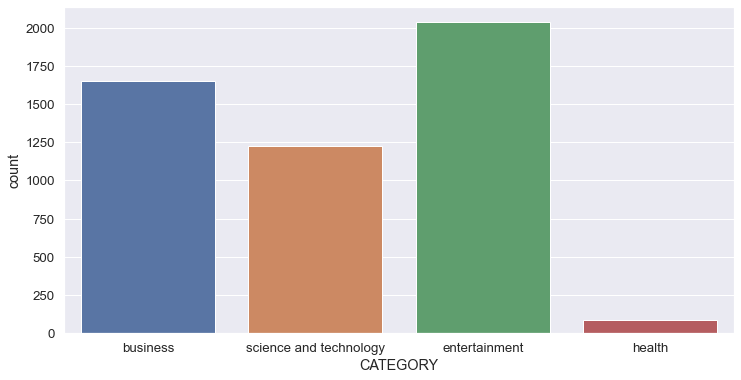

In [8]:
def label_to_name(label):
    if(label=='e'):
        return 'entertainment'
    elif(label=='b'):
        return 'business'
    elif(label=='t'):
        return 'science and technology'
    else:
        return 'health'
    
df['CATEGORY'] = df['CATEGORY'].apply(label_to_name)
print('Distribution of labels in %\n')
print(df['CATEGORY'].value_counts()/df.shape[0]*100)

sns.set(font_scale=1.2)
plt.figure(figsize=(12,6))
sns.countplot(df['CATEGORY']);

### Drop unused features
- Dropping features [ID,URL,PUBLISHER,STORY,HOSTNAME,TIMESTAMP]
- Lowercasing text in 'TITLE' column
- Removing Punctuation
- Removing StopWords
- Lemmatizing (since Stemming may create non-existent/incorrect words)
- Removing emojis if any (None were found)
- Removing emoticons (None were found)

In [9]:
df.drop(columns=['ID','URL','PUBLISHER','STORY','HOSTNAME','TIMESTAMP'],inplace=True)


# lowercasing
df['lower'] = df['TITLE'].str.lower()



PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
df["punc_removed"] = df["lower"].apply(lambda text: remove_punctuation(text))



STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df["stopwords_removed"] = df["punc_removed"].apply(lambda text: remove_stopwords(text))


df.head()

,TITLE,CATEGORY,lower,punc_removed,stopwords_removed
0,"Fed official says weak data caused by weather,...",business,"fed official says weak data caused by weather,...",fed official says weak data caused by weather ...,fed official says weak data caused weather slo...
1,Fed's Charles Plosser sees high bar for change...,business,fed's charles plosser sees high bar for change...,feds charles plosser sees high bar for change ...,feds charles plosser sees high bar change pace...
2,US open: Stocks fall after Fed official hints ...,business,us open: stocks fall after fed official hints ...,us open stocks fall after fed official hints a...,us open stocks fall fed official hints acceler...
3,"Fed risks falling 'behind the curve', Charles ...",business,"fed risks falling 'behind the curve', charles ...",fed risks falling behind the curve charles plo...,fed risks falling behind curve charles plosser...
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,business,fed's plosser: nasty weather has curbed job gr...,feds plosser nasty weather has curbed job growth,feds plosser nasty weather curbed job growth


### WORDCLOUD

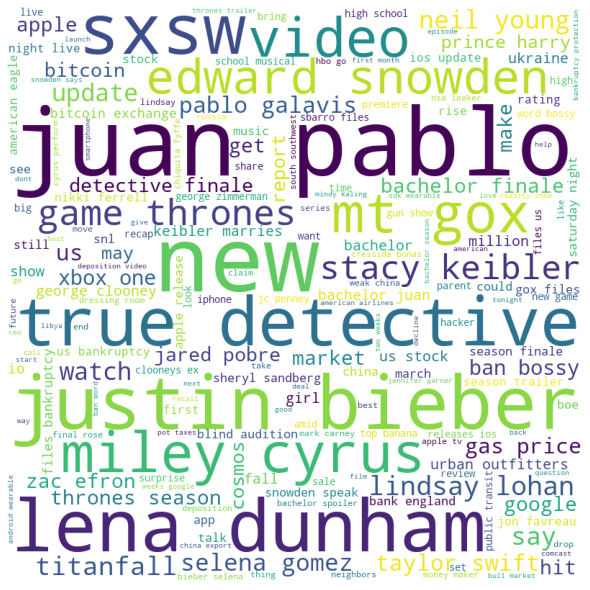

In [10]:
comment_words = ' '
stopwords = set(STOPWORDS) 
  

for val in df.stopwords_removed[0:10000]:  
    tokens = val.split()     
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

## Feature extraction

### Dealing with Categorical Data

In [11]:
le = LabelEncoder()
df['CATEGORY']=le.fit_transform(df['CATEGORY'])

df.head(3)

,TITLE,CATEGORY,lower,punc_removed,stopwords_removed
0,"Fed official says weak data caused by weather,...",0,"fed official says weak data caused by weather,...",fed official says weak data caused by weather ...,fed official says weak data caused weather slo...
1,Fed's Charles Plosser sees high bar for change...,0,fed's charles plosser sees high bar for change...,feds charles plosser sees high bar for change ...,feds charles plosser sees high bar change pace...
2,US open: Stocks fall after Fed official hints ...,0,us open: stocks fall after fed official hints ...,us open stocks fall after fed official hints a...,us open stocks fall fed official hints acceler...


### Results using CountVectorizer

In [13]:
# convert data into vectors
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df['stopwords_removed'])
y = df['CATEGORY']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=df.CATEGORY)
print('Training Data ',x_train.shape,y_train.shape)
print('Test Data     ',x_test.shape,y_test.shape)


results = pd.DataFrame(columns=['Model','Accuracy','F1-score'])

models_name = ['Logistic Regression','Decision Tree','Multinomial NaiveBayes']

model_list = [LogisticRegression(), DecisionTreeClassifier(),MultinomialNB()]

for idx,model in enumerate(model_list):
    clf = model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    results.loc[idx] = [models_name[idx],accuracy_score(y_test, predictions),f1_score(y_test, predictions, average = 'weighted')]

results.sort_values(by='Accuracy',inplace=True,ascending=False)
results

Training Data  (4000, 5768) (4000,)
Test Data      (1000, 5768) (1000,)


,Model,Accuracy,F1-score
0,Logistic Regression,0.971,0.970701
2,Multinomial NaiveBayes,0.961,0.960669
1,Decision Tree,0.945,0.944820


### 

### Results using TF-IDF

In [14]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df['stopwords_removed'].values)
y = df['CATEGORY']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=df.CATEGORY)
print('Training Data ',x_train.shape,y_train.shape)
print('Test Data     ',x_test.shape,y_test.shape)


results = pd.DataFrame(columns=['Model','Accuracy','F1-score'])

models_name = ['Logistic Regression','Decision Tree','Multinomial NaiveBayes']

model_list = [LogisticRegression(), DecisionTreeClassifier(),MultinomialNB()]

for idx,model in enumerate(model_list):
    clf = model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    results.loc[idx] = [models_name[idx],accuracy_score(y_test, predictions),f1_score(y_test, predictions, average = 'weighted')]

results.sort_values(by='Accuracy',inplace=True,ascending=False)
results

Training Data  (4000, 5768) (4000,)
Test Data      (1000, 5768) (1000,)


,Model,Accuracy,F1-score
0,Logistic Regression,0.961,0.958629
2,Multinomial NaiveBayes,0.950,0.942950
1,Decision Tree,0.943,0.942822


## Training, prediction and evaluate model. 

### Using LSTM for training Deep Learning model

In [15]:
labels = to_categorical(df['CATEGORY'], num_classes=4)

n_most_common_words = 10000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df["lower"].values)
sequences = tokenizer.texts_to_sequences(df["lower"].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.2, random_state=42,stratify=df.CATEGORY)

epochs = 10
emb_dim = 150
batch_size = 256

Found 6173 unique tokens.


In [22]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.15, recurrent_dropout=0.15))

model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test,y_test),callbacks=callbacks_list)

((4000, 130), (4000, 4), (1000, 130), (1000, 4))
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 130, 150)          1500000   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 130, 150)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               100400    
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 1,600,804
Trainable params: 1,600,804
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
16/16 [==============================] - ETA:

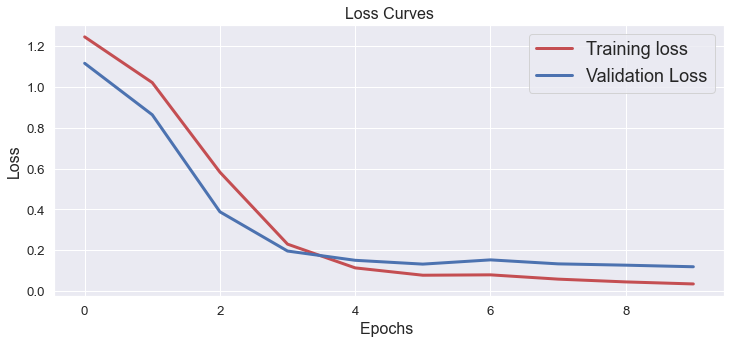

In [23]:
fig1 = plt.figure(figsize=(12,5))
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
#fig1.savefig('loss.png')
plt.show()

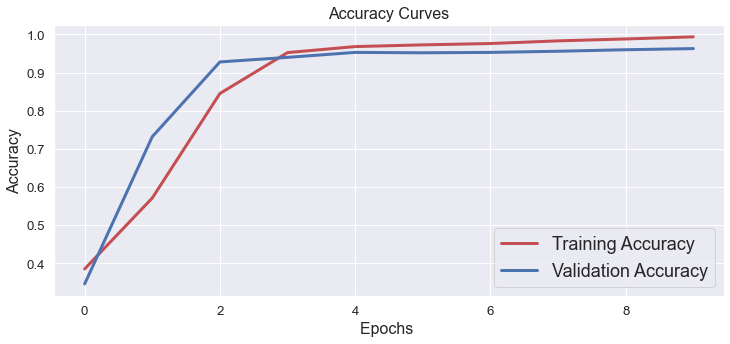

In [24]:
fig2=plt.figure(figsize=(12,5))
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
#fig2.savefig('accuracy.png')
plt.show()

In [29]:
print('** Results for LSTM Model **\n')
predictions = np.argmax(model.predict(X_test), axis=-1)
print("Accuracy score: ", accuracy_score(y_test.argmax(1), predictions)) # to convert OHE vector back to label
print("F1 score: ", f1_score(y_test.argmax(1), predictions, average = 'weighted'))

** Results for LSTM Model **

Accuracy score:  0.963
F1 score:  0.9622283620518916
